In [1]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from regions import DS9Parser, read_ds9
from regions import PixCoord, CirclePixelRegion,RectanglePixelRegion, PolygonPixelRegion,EllipsePixelRegion, PolygonSkyRegion

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [2]:
cat_ch1 = Table.read('deepdrill/deepdrill_xmm_20may17_chan1_cat_v2.fits')
cat_ch2 = Table.read('deepdrill/deepdrill_xmm_20may17_chan2_cat_v2.fits')

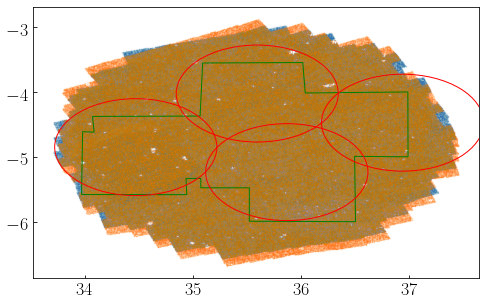

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5),sharex=True)
plt.scatter(cat_ch1['ra'],cat_ch1['dec'],s=0.1,alpha=0.1)
plt.scatter(cat_ch2['ra'],cat_ch2['dec'],s=0.1,alpha=0.1)

colors=['b','g','r']
xmm_reg_filelist = ['MegaCam_u_xmm.reg','MegaCam_uS_deep_xmm.reg','HSC_xmm.reg']
xmm_radec_lim = [33,38,-7,-3]
for i,filename in enumerate(xmm_reg_filelist):
    file = open('../regions/'+filename)
    lines = file.readlines()
    for line in lines:
        if 'polygon' in line:
            line = 'wcs; fk5\n '+line.rstrip()
            region = DS9Parser(line).shapes.to_regions()[0]
            vertices = region.vertices
            pixel_vertex_x = []
            pixel_vertex_y = []
            for vertex in vertices:
                pixel_vertex_x.append(vertex.ra.value)
                pixel_vertex_y.append(vertex.dec.value)
                pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
            
            artist = pixel_region.as_artist(edgecolor=colors[i],fill=False)        
            ax.add_artist(artist)
        
        elif 'circle' in line:
            line = 'wcs; fk5\n '+line.rstrip()
            region = DS9Parser(line).shapes.to_regions()[0]
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            pixel_ra_axis = region.radius.value/np.cos(region.center.dec.value/180*np.pi)/3600
            pixel_dec_axis = region.radius.value/3600
            pixel_region = EllipsePixelRegion(pixel_center, pixel_ra_axis*2,pixel_dec_axis*2)
        
            artist = pixel_region.as_artist(edgecolor=colors[i],fill=False)        
            ax.add_artist(artist)
            

#### Convert flux to magnitude

In [29]:
def flux2mag(fluxes):
    # flux in microJanksky
    # mags in AB
    return  2.5*(23-np.log10(fluxes/1e6))-48.6

In [30]:
mag_ch1 = flux2mag(cat_ch1['FluxAuto_3p6'])
mag_ch1[np.isnan(mag_ch1)]=99

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [39]:
# add mag info to the catalogs
cat_ch1 = Table.read('deepdrill/deepdrill_xmm_20may17_chan1_cat_v2.fits')

mag_ch1 = flux2mag(cat_ch1['FluxAuto_3p6'])
mag_ch1[np.isnan(mag_ch1)]=99    
col_magch1 = Column(name='mag_auto_ch1',data=mag_ch1)

mag_ch1_inf = flux2mag(cat_ch1['FluxAuto_3p6']-cat_ch1['FluxErrAuto_3p6'])
mag_ch1_inf[np.isnan(mag_ch1_inf)]=99  
col_magch1_inf = Column(name='mag_auto_ch1_inf',data=mag_ch1_inf)

mag_ch1_sup = flux2mag(cat_ch1['FluxAuto_3p6']+cat_ch1['FluxErrAuto_3p6'])
mag_ch1_sup[np.isnan(mag_ch1_sup)]=99  
col_magch1_sup = Column(name='mag_auto_ch1_sup',data=mag_ch1_sup)

if 'mag_auto_ch1_sup' in cat_ch1.keys():
    cat_ch1.remove_columns(['mag_auto_ch1','mag_auto_ch1_inf','mag_auto_ch1_sup'])
cat_ch1.add_columns([col_magch1,col_magch1_inf,col_magch1_sup])
cat_ch1.write('deepdrill/deepdrill_xmm_20may17_chan1_cat_v2_mag.fits',overwrite=True)

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [40]:
# add mag info to the catalogs
cat_ch2 = Table.read('deepdrill/deepdrill_xmm_20may17_chan2_cat_v2.fits')

mag_ch2 = flux2mag(cat_ch2['FluxAuto_4p5'])
mag_ch2[np.isnan(mag_ch2)]=99    
col_magch2 = Column(name='mag_auto_ch2',data=mag_ch2)

mag_ch2_inf = flux2mag(cat_ch2['FluxAuto_4p5']-cat_ch2['FluxErrAuto_4p5'])
mag_ch2_inf[np.isnan(mag_ch2_inf)]=99  
col_magch2_inf = Column(name='mag_auto_ch2_inf',data=mag_ch2_inf)

mag_ch2_sup = flux2mag(cat_ch2['FluxAuto_4p5']+cat_ch2['FluxErrAuto_4p5'])
mag_ch2_sup[np.isnan(mag_ch2_sup)]=99  
col_magch2_sup = Column(name='mag_auto_ch2_sup',data=mag_ch2_sup)

if 'mag_auto_ch1_sup' in cat_ch2.keys():
    cat_ch2.remove_columns(['mag_auto_ch2','mag_auto_ch2_inf','mag_auto_ch2_sup'])
cat_ch2.add_columns([col_magch2,col_magch2_inf,col_magch2_sup])
cat_ch2.write('deepdrill/deepdrill_xmm_20may17_chan2_cat_v2_mag.fits',overwrite=True)

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


#### gzCH1 plot

In [83]:
cat_added = Table.read('/Volumes/LejaySSD/XMM-LSS_deep_CLAUDS_v9_CH1_CH2.fits')
cat_added_shiraz = Table.read('/Volumes/LejaySSD/COSMOS_deep_CLAUDS_v9_CH1_CH2_corr.fits')

In [86]:
# sample size
cat_size = 500000
select_ids = np.random.choice(np.arange(len(cat_added)), size=cat_size, replace=False)
cat_added_select = cat_added[select_ids]

# magnitude cut
mag_cut = 20
cat_added_select = cat_added_select[cat_added_select['i']<mag_cut]
cat_added_select = cat_added_select[cat_added_select['i']>-90]

select_ids = np.random.choice(np.arange(len(cat_added_shiraz)), size=cat_size, replace=False)
cat_added_shiraz_select = cat_added_shiraz[select_ids]
cat_added_shiraz_select = cat_added_shiraz_select[cat_added_shiraz_select['i']<mag_cut]
cat_added_shiraz_select = cat_added_shiraz_select[cat_added_shiraz_select['i']>-90]

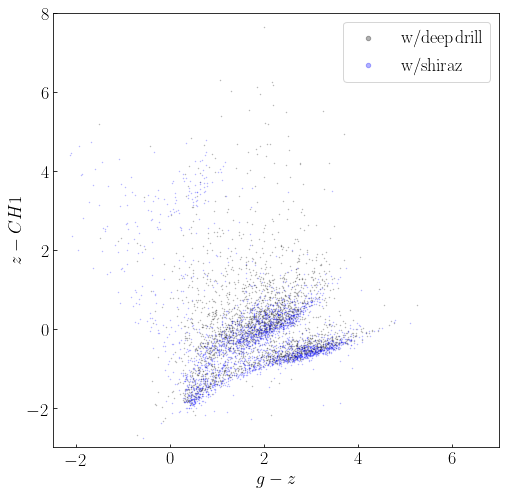

In [87]:
fig, axs = plt.subplots(1, 1, figsize = (8, 8),sharex=True)

plt.scatter(cat_added_select['g']-cat_added_select['z'],cat_added_select['z']-cat_added_select['MAG_AUTO_CH1'],color='k',s=0.2,alpha=0.3,label='w/deepdrill')
plt.scatter(cat_added_shiraz_select['g']-cat_added_shiraz_select['z'],cat_added_shiraz_select['z']-cat_added_shiraz_select['MAG_AUTO_CH1'],color='b',s=0.2,alpha=0.3,label='w/shiraz')

plt.xlim(-2.5,7)
plt.ylim(-3,8)
plt.xlabel('$g-z$',fontsize=18)
plt.ylabel('$z-CH1$',fontsize=18)
plt.legend(fontsize=18,markerscale=10)
plt.show()

In [88]:
mag_cut = 26
gz = 3
gz_width = 0.5

cat_added_select2 = cat_added[cat_added['i']<mag_cut]
cat_added_select2 = cat_added_select2[cat_added_select2['i']>-90]
cat_added_select2 = cat_added_select2[abs(cat_added_select2['g']-cat_added_select2['z']-gz)<gz_width]
print(len(cat_added_select2))

cat_added_shiraz_select2 = cat_added_shiraz[cat_added_shiraz['i']<mag_cut]
cat_added_shiraz_select2 = cat_added_shiraz_select2[cat_added_shiraz_select2['i']>-90]
cat_added_shiraz_select2 = cat_added_shiraz_select2[abs(cat_added_shiraz_select2['g']-cat_added_shiraz_select2['z']-gz)<gz_width]
print(len(cat_added_shiraz_select2))

108919
174005


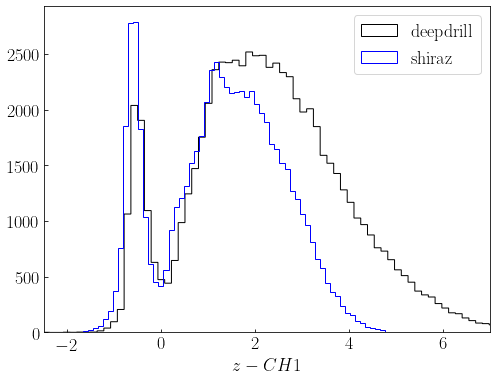

In [93]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6),sharex=True)

plt.hist(cat_added_select2['z']-cat_added_select2['MAG_AUTO_CH1'],bins='scott',color='k',histtype='step',label='deepdrill')
plt.hist(cat_added_shiraz_select2['z']-cat_added_shiraz_select2['MAG_AUTO_CH1'],color='b',bins='scott',histtype='step',label='shiraz')

plt.xlim(-2.5,7)
plt.xlabel('$z-CH1$',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [73]:
cat_deepdrill = Table.read('/Volumes/LejaySSD/deepdrill/deepdrill_xmm_20may17_chan1_cat_v2_mag.fits')
cat_shiraz = Table.read('/Volumes/LejaySSD/SHIRAZ_catalogs/COSMOS_scosmos_ext_CH1_trim.fits')

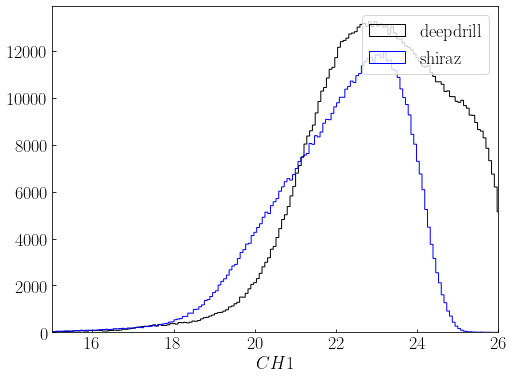

In [91]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6),sharex=True)

plt.hist(cat_deepdrill['mag_auto_ch1']+2.5,bins='scott',color='k',histtype='step',label='deepdrill')
plt.hist(cat_shiraz['MAG_AUTO_CH1'],color='b',bins='scott',histtype='step',label='shiraz')
plt.xlim(15,26)
plt.xlabel('$CH1$',fontsize=18)
plt.legend(fontsize=18)
plt.show()